# Neo4j configuration guide

This notebook walks through basic code examples for integrating various packages with Neo4j, including `py2neo`, `ipython-cypher`, `pandas`, `neo4jupyter`, `networkx` and `jgraph`. It helps you configure Neo4j depending of your environment. 

# Installation

In case you are running Serenata de Amor using Docker, then you already have a Neo4j container up and running. However, if you are using Serenata de Amor outside Docker, you need to run **$ docker-compose up -d neo4j** to start the container.

To stop it just run **$ docker-compose down neo4j**. The data stored in Neo4j will be stored in folder **serenata-de-amor-instalation-path/data/neo4j/data**.

Now you gonna check installation. Jupyter and Neo4j integration is done using `py2neo` package. `py2neo` is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j.

### Connecting

To connect to Neo4j with the `Graph` class you need tell it what is Neo4j address. If you are running it from a traditional installation or as a Docker container, as described in CONTRIBUTING.MD, you can instantiate `Graph` class just like this:

In [13]:
from py2neo import Graph
graph = Graph()

or

In [14]:
graph = Graph('http://localhost:7474')

If you are using both serenata de amor and neo4j inside docker containers you need to instantiate the Graph object pointing to **http://neo4j:7474** like this:

In [15]:
try:
    graph = Graph('http://neo4j:7474')
except:
    print('Neo4j not found. Maybe it is not runnning inside a container...')

Neo4j not found. Maybe it is not runnning inside a container...


To delete the entire graph database just run:

In [16]:
graph.delete_all()

# Using py2neo

## Nodes

Create nodes with the `Node` class. The first argument is the node's label. The remaining arguments are an arbitrary amount of node properties or key-value pairs.

In [17]:
from py2neo import Node

nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

graph.create(nicole | drew | mtdew | cokezero | coke | pepsi)

## Relationships

Create relationships between nodes with the `Relationship` class.

In [18]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))

## Neo4jupyter

`neo4jupyter` is a python package that helps in drawing graphs inside Jupyter notebooks.

The first thing after import the package is run `neo4jupyter.init_notebook_mode()` in order to setup the required scripts.

In [19]:
import neo4jupyter

neo4jupyter.init_notebook_mode()

<IPython.core.display.Javascript object>

In [20]:
from neo4jupyter import draw

options = {"Person": "name", "Drink": "name", "Manufacturer": "name"}
draw(graph, options)

## Cypher

Retrieve Cypher query results with `Graph.run`.

In [21]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = graph.run(query)

for d in data:
    print(d)

('name': 'Nicole', 'drink': 'Mountain Dew')
('name': 'Nicole', 'drink': 'Coke Zero')
('name': 'Drew', 'drink': 'Mountain Dew')


## Parameterized Cypher

Pass parameters to Cypher queries by passing additional key-value arguments to `Graph.run`. Parameters in Cypher are named and are wrapped in curly braces.

In [22]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.run(query, name="Nicole")

for d in data:
    print(d)

('name': 'Nicole', 'avg_calories': 4500.0)


# ipython-cypher

`ipython-cypher` exposes `%cypher` magic in Jupyter. Install `ipython-cypher` with `pip install ipython-cypher`.

In [23]:
%load_ext cypher

## Cypher

`%cypher` is intended for one-line Cypher queries and `%%cypher` is intended for multi-line Cypher queries. Placing `%%cypher` above a Cypher query will display that query's results.

In [24]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Mountain Dew,9000
Nicole,Coke Zero,0
Drew,Mountain Dew,9000


## Pandas Data Frames

Cypher query results can be coerced to `pandas` data frames with the `get_dataframe` method. To assign Cypher query results to a variable, you need to use `%cypher` and separate lines with \\. You'll first need to install `pandas` with `pip install pandas`.

In [25]:
results = %cypher MATCH (person:Person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Nicole,Mountain Dew
1,Nicole,Coke Zero
2,Drew,Mountain Dew


## NetworkX Graphs

Cypher query results can be coerced to `NetworkX` MultiDiGraphs, graphs that permit multiple edges between nodes, with the `get_graph` method. You'll first need to install `NetworkX` with `pip install networkx`.

3 rows affected.


/home/marcus/anaconda/envs/serenata_de_amor/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/marcus/anaconda/envs/serenata_de_amor/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/marcus/anaconda/envs/serenata_de_amor/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/marcus/anaconda/envs/serenata_de_amor/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserW

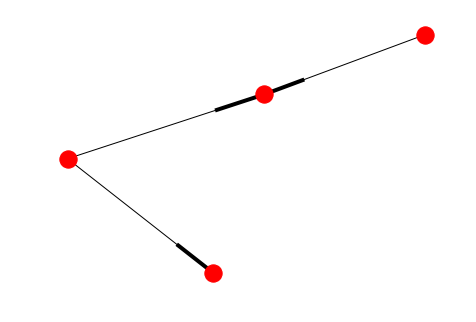

In [26]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [27]:
g.nodes(data=True)

[('5382', {'age': 24, 'labels': ['Person'], 'name': 'Nicole'}),
 ('5385', {'calories': 0, 'labels': ['Drink'], 'name': 'Coke Zero'}),
 ('5383', {'calories': 9000, 'labels': ['Drink'], 'name': 'Mountain Dew'}),
 ('5384', {'age': 20, 'labels': ['Person'], 'name': 'Drew'})]

In [28]:
nx.degree(g)

{'5382': 2, '5383': 2, '5384': 1, '5385': 1}

# jgraph

`jgraph` will plot tuple lists as 3D graphs.

In [29]:
import jgraph

jgraph.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])